In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import torch
import lightning.pytorch as pl

from pathlib import Path
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, NaNLabelEncoder
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer, EncoderNormalizer, TorchNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
df = pd.read_csv("Maldives_data_1.csv")

In [3]:
df['err_vgosa'].fillna(int(df['err_vgosa'].mean()), inplace=True)
df['err_ugosa'].fillna(int(df['err_ugosa'].mean()), inplace=True)

In [4]:
df.head()

,time,latitude,longitude,adt,err_sla,err_ugosa,err_vgosa,flag_ice,sla,tpa_correction,ugos,ugosa,vgos,vgosa
0,1993-01-01,0.875,72.875,0.7483,0.0162,0.0,0.0,0.0,-0.0171,0.0061,-0.2200,-0.3054,-0.0533,-0.0791
1,1993-01-01,0.875,73.125,0.7443,0.0171,0.0,0.0,0.0,-0.0216,0.0061,-0.2363,-0.2918,-0.0089,-0.0454
2,1993-01-01,0.875,73.375,0.7455,0.0176,0.0,0.0,0.0,-0.0211,0.0061,-0.2631,-0.2803,0.1029,0.0581
3,1993-01-01,0.875,73.625,0.7508,0.0175,0.0,0.0,0.0,-0.0167,0.0061,-0.3532,-0.3364,0.1147,0.0674
4,1993-01-01,1.125,72.875,0.7471,0.0160,0.0,0.0,0.0,-0.0183,0.0061,-0.2254,-0.2747,0.0434,-0.0082


In [5]:
#Filtering Out Maldives Latitude and Longitude
df = df[(df['latitude'] == 3.125) & (df['longitude'] == 73.125)]

In [6]:
df["time"] = pd.to_datetime(df["time"])
df["time_idx"] = (df["time"] - df["time"].min()).dt.days

#df['flag_ice'] = df['flag_ice'].astype(str)

In [7]:
max_prediction_length = 1095
max_encoder_length = df.index.nunique()
training_cutoff = df["time_idx"].max() - max_prediction_length

time_varying_known_reals = ['time_idx']
time_varying_unknown_reals = ['sla','flag_ice','err_sla', 'ugosa', 'err_ugosa', 'vgosa', 'err_vgosa',
                              'adt', 'ugos', 'vgos']


training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sla",
    group_ids=["latitude", "longitude"],
    categorical_encoders={
         "latitude": NaNLabelEncoder(add_nan=True).fit(df["latitude"]),
         "longitude": NaNLabelEncoder(add_nan=True).fit(df["longitude"])
     },
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_reals=["latitude","longitude"],
    time_varying_known_reals= time_varying_known_reals,
    time_varying_unknown_reals= time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(), 
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [8]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(0.0266)

In [9]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    output_size = 7,
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 11.5k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.06760829753919811
Restoring states from the checkpoint path at /Users/bhavya/Documents/Sea-Level-Rise-Challenge/.lr_find_b7733b23-049d-4b0a-b8ef-030cff810837.ckpt
Restored all states from the checkpoint at /Users/bhavya/Documents/Sea-Level-Rise-Challenge/.lr_find_b7733b23-049d-4b0a-b8ef-030cff810837.ckpt


suggested learning rate: 0.06760829753919811


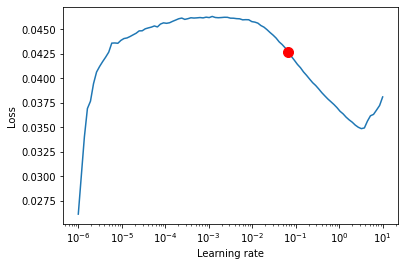

In [10]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [10]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.06,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 26.3k


In [11]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
   
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 272   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [12]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [13]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(0.0419)

In [14]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

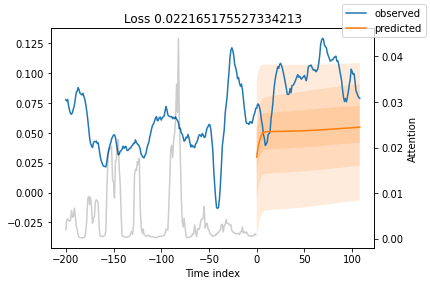

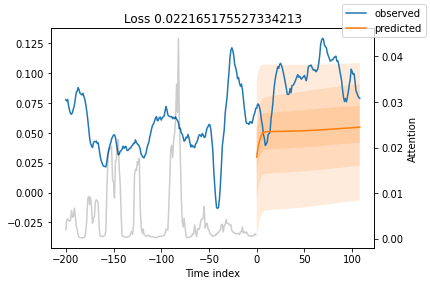

In [15]:
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

{'latitude': <Figure size 720x360 with 2 Axes>,
 'longitude': <Figure size 720x360 with 2 Axes>,
 'encoder_length': <Figure size 720x360 with 2 Axes>,
 'sla_center': <Figure size 720x360 with 2 Axes>,
 'sla_scale': <Figure size 720x360 with 2 Axes>,
 'time_idx': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'sla': <Figure size 720x360 with 2 Axes>,
 'flag_ice': <Figure size 720x360 with 2 Axes>,
 'err_sla': <Figure size 720x360 with 2 Axes>,
 'ugosa': <Figure size 720x360 with 2 Axes>,
 'err_ugosa': <Figure size 720x360 with 2 Axes>,
 'vgosa': <Figure size 720x360 with 2 Axes>,
 'err_vgosa': <Figure size 720x360 with 2 Axes>,
 'adt': <Figure size 720x360 with 2 Axes>,
 'ugos': <Figure size 720x360 with 2 Axes>,
 'vgos': <Figure size 720x360 with 2 Axes>}

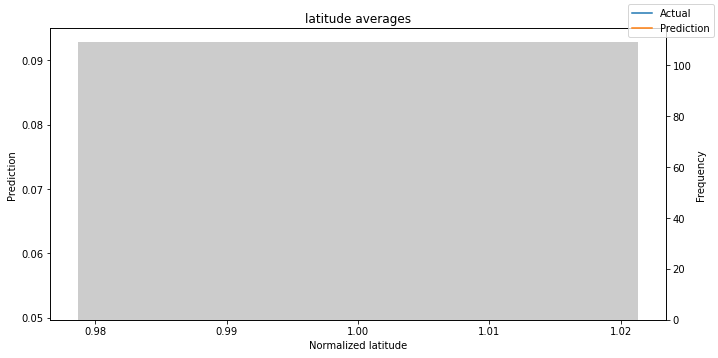

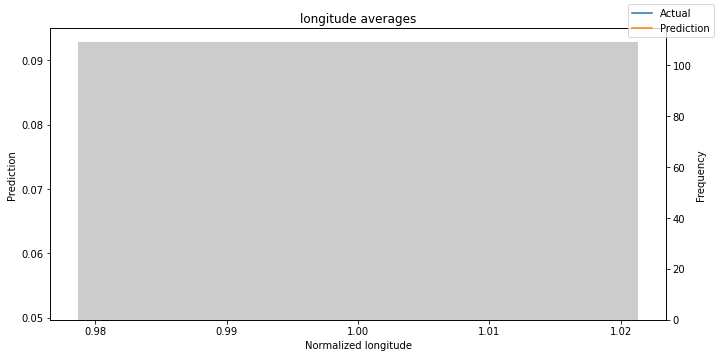

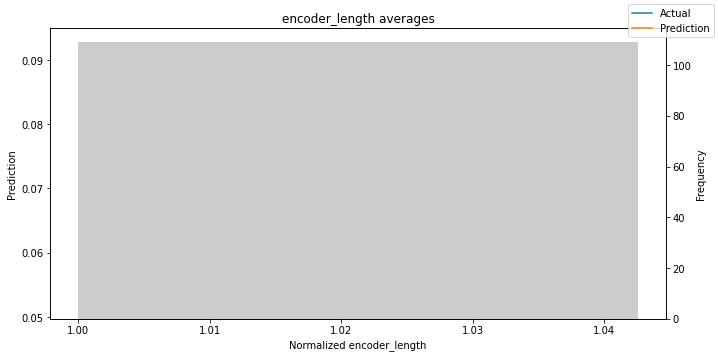

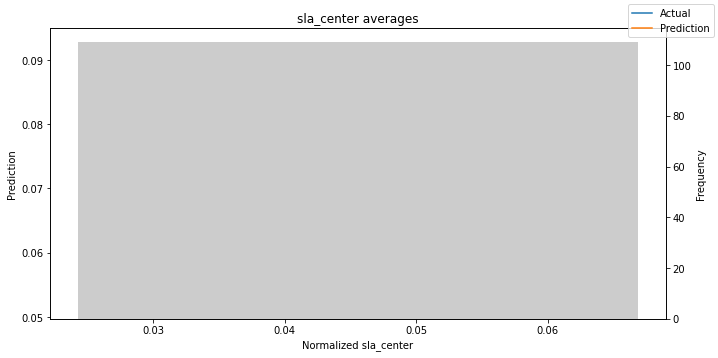

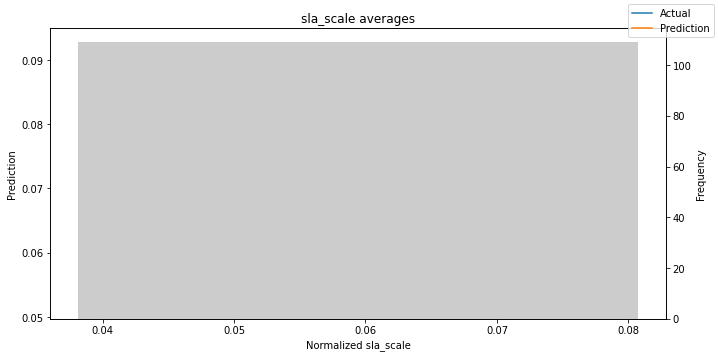

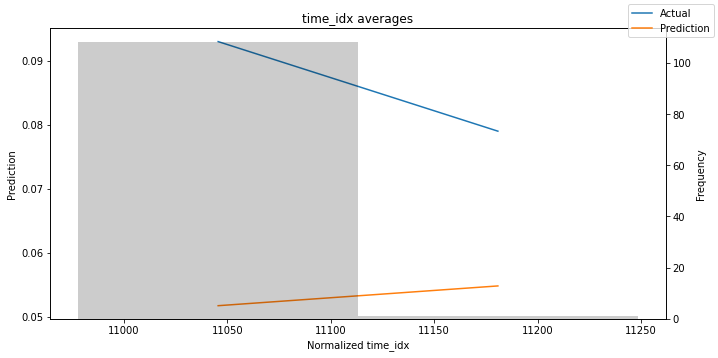

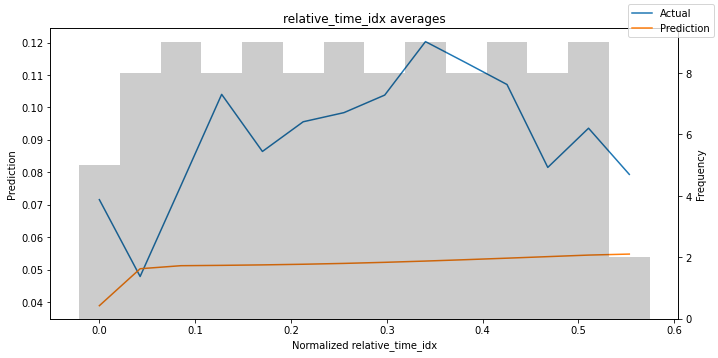

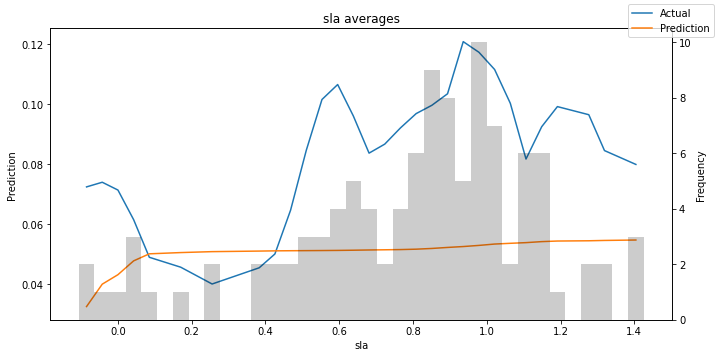

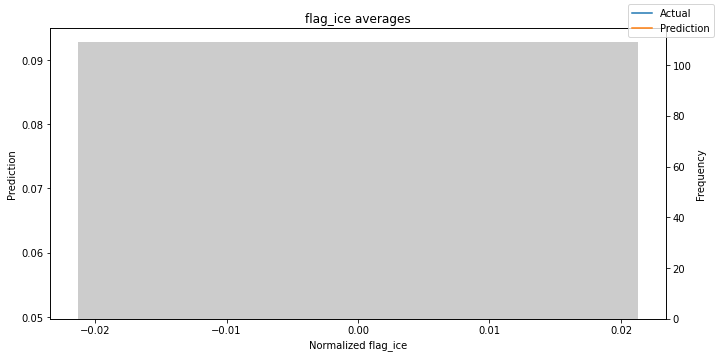

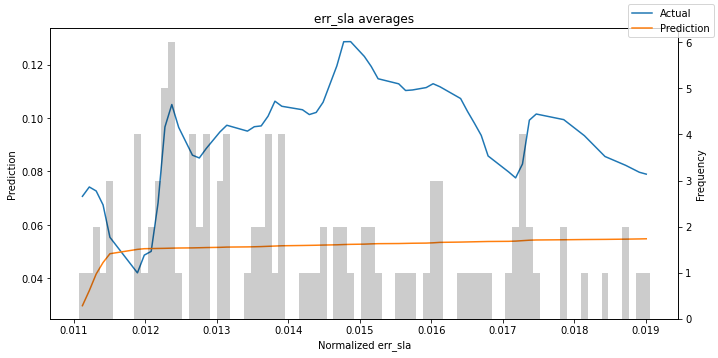

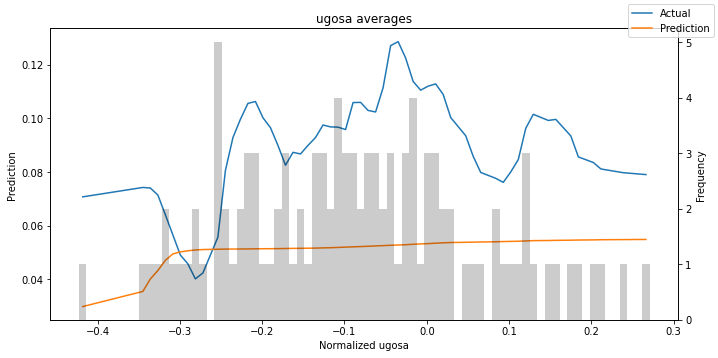

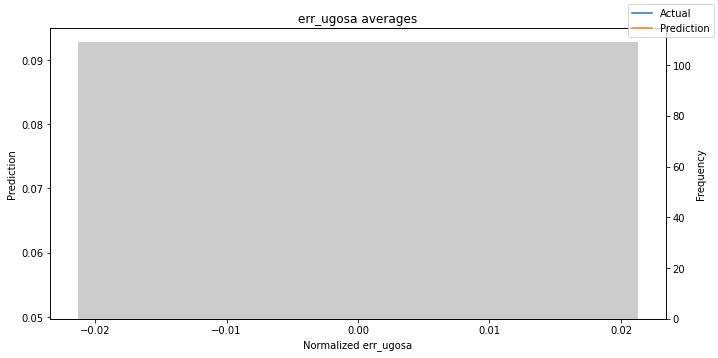

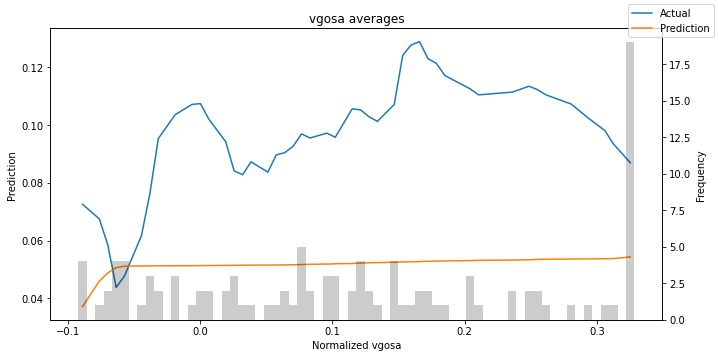

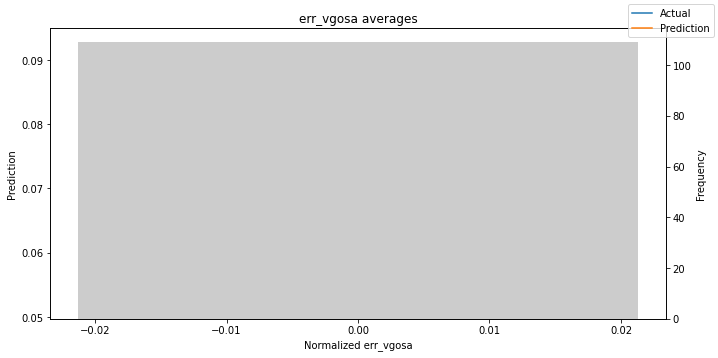

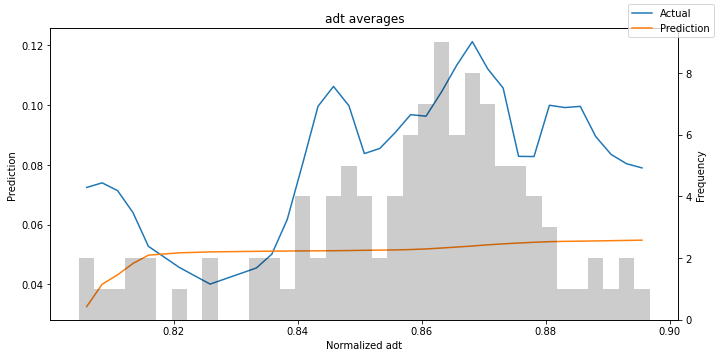

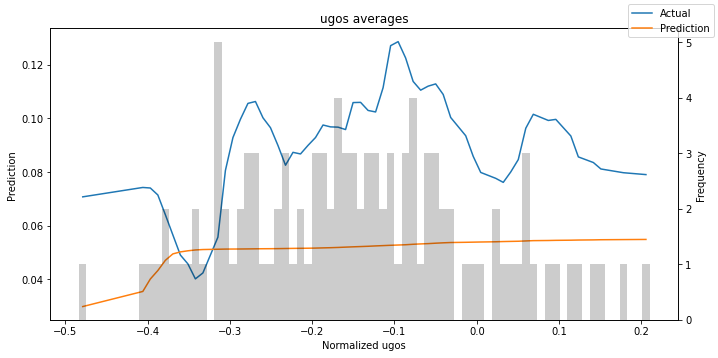

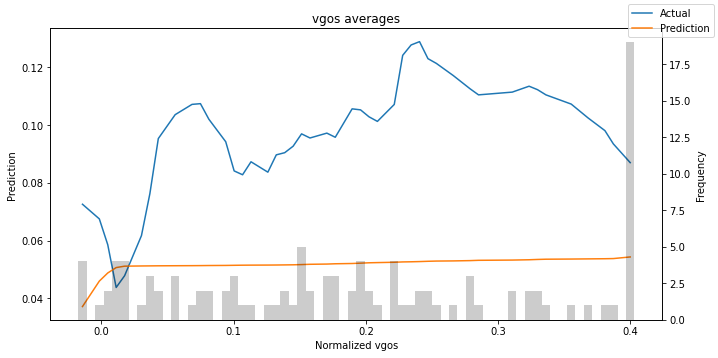

In [16]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
df["time"] = pd.to_datetime(df["time"])
df["time_idx"] = (df["time"] - df["time"].min()).dt.days

In [30]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = df[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = df[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
     [last_data.assign(time=lambda x: x.time + pd.offsets.Day(i)) for i in range(1, max_prediction_length + 1)],
     ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = (decoder_data["time"] - decoder_data["time"].min()).dt.days
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# # adjust additional time feature(s)
# decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [31]:
new_prediction_data

,time,latitude,longitude,adt,err_sla,err_ugosa,err_vgosa,flag_ice,sla,tpa_correction,ugos,ugosa,vgos,vgosa,time_idx
0,2022-11-20,3.125,73.125,0.8291,0.0131,0.0,0.0,0.0,0.0637,0.0,-0.1130,-0.0523,0.4254,0.3508,10915
1,2022-11-21,3.125,73.125,0.8289,0.0123,0.0,0.0,0.0,0.0635,0.0,-0.0487,0.0121,0.4322,0.3576,10916
2,2022-11-22,3.125,73.125,0.8291,0.0120,0.0,0.0,0.0,0.0637,0.0,-0.0282,0.0326,0.4577,0.3831,10917
3,2022-11-23,3.125,73.125,0.8273,0.0122,0.0,0.0,0.0,0.0619,0.0,-0.0552,0.0056,0.4985,0.4239,10918
4,2022-11-24,3.125,73.125,0.8285,0.0127,0.0,0.0,0.0,0.0631,0.0,-0.0210,0.0397,0.5205,0.4459,10919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2023-09-20,3.125,73.125,0.8444,0.0113,0.0,0.0,0.0,0.0790,0.0,-0.1555,-0.0948,0.0659,-0.0087,11219
305,2023-09-21,3.125,73.125,0.8444,0.0113,0.0,0.0,0.0,0.0790,0.0,-0.1555,-0.0948,0.0659,-0.0087,11220
306,2023-09-22,3.125,73.125,0.8444,0.0113,0.0,0.0,0.0,0.0790,0.0,-0.1555,-0.0948,0.0659,-0.0087,11221
307,2023-09-23,3.125,73.125,0.8444,0.0113,0.0,0.0,0.0,0.0790,0.0,-0.1555,-0.0948,0.0659,-0.0087,11222


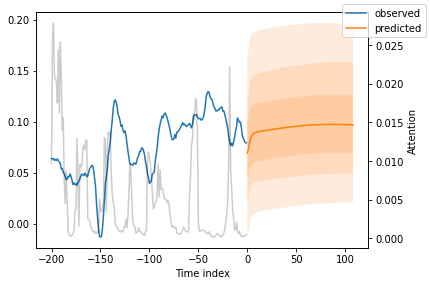

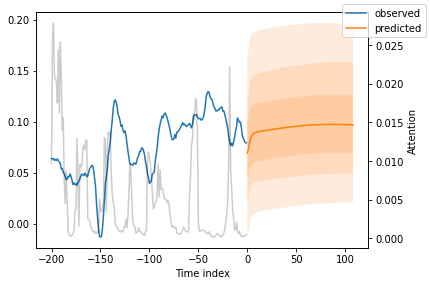

In [34]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=False)